In [3]:
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import scipy
from scipy import ndimage

from features import rgb2gray

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


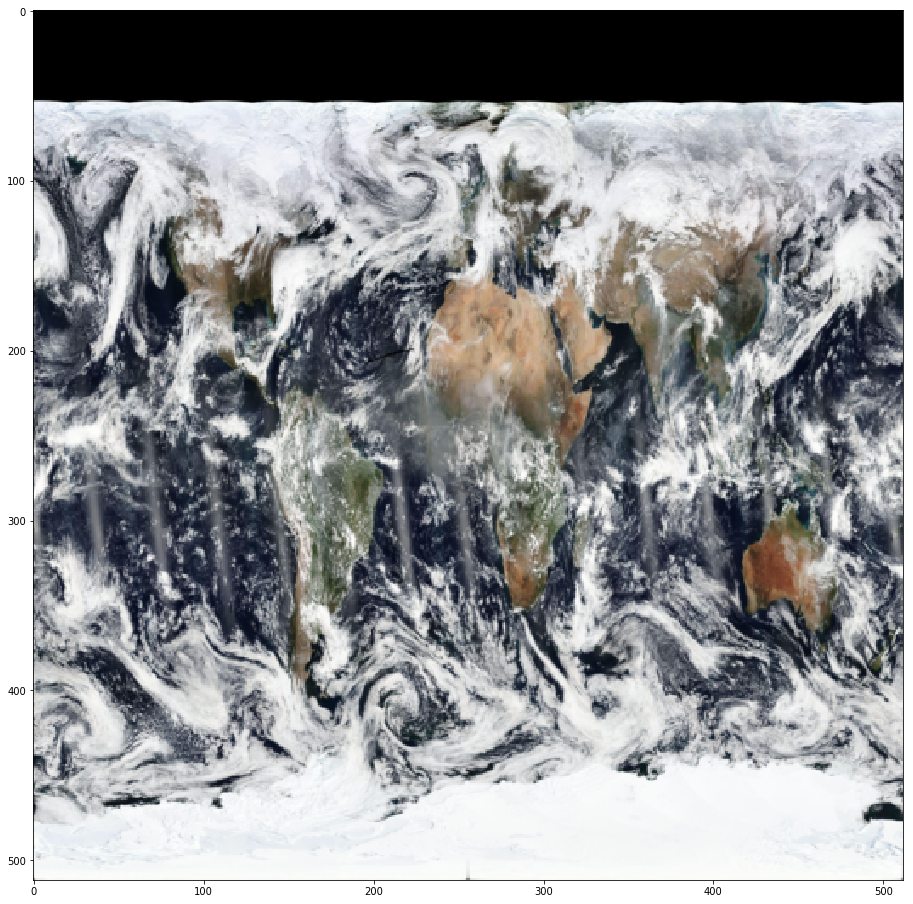

In [163]:
# ECLIPSE: 2016-09-01, 2017-02-26, 2016-03-09, 2018-02-15 (solar-no missing data)
# TINY HOLE: 2016-01-30, 2016-04-21
# THIN HOLE: 2016-02-07
# BIG HOLE: 2015-11-25, 2016-12-20, 2017-03-30, 2017-03-31, 2017-04-01, 2017-09-29, 2017-11-30, 2017-12-30, 2018-01-29
# JAGGED STITCH: 2016-05-26, 2017-05-08
date = "2016-02-07"
example_img_file = "data/4326/" + date + "/VIIRS_SNPP_CorrectedReflectance_TrueColor.jpg"
img_size =  (512, 512)
# (4096, 2048)
image = np.asarray(Image.open(example_img_file).resize(img_size, Image.BILINEAR))
plt.imshow(image)

0.10282135009765625
0


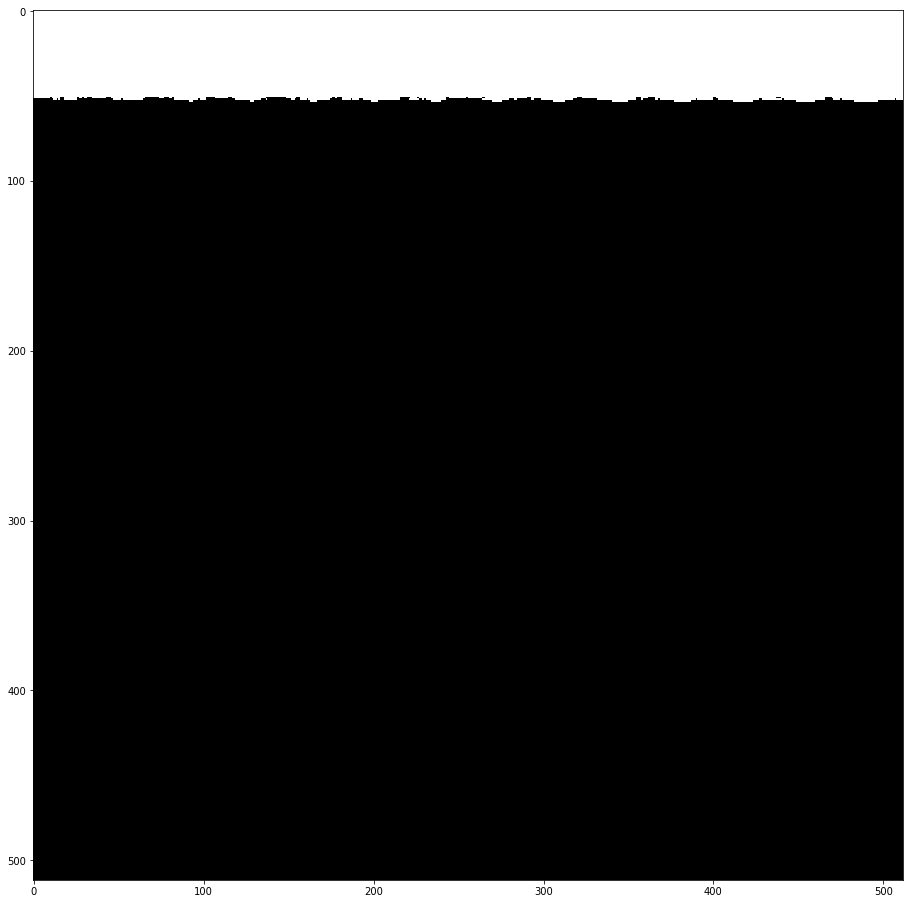

In [164]:
# Grayscale the image
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to black and white
_, im_thresh = cv2.threshold(imgray, 0, 255, cv2.THRESH_BINARY_INV)
plt.imshow(im_thresh)

# Copy the thresholded image
im_floodfill = im_thresh.copy()
ratio_missing = 1.0 - (im_floodfill == 0).sum() / im_floodfill.size
print(ratio_missing)

# # Expand tiny holes slightly
# large_kernel = np.ones((3,3),np.uint8)
# im_floodfill = cv2.dilate(im_floodfill, large_kernel, iterations = 1)

# Shrink in very small holes
small_kernel = np.ones((4,4),np.uint8)
# im_floodfill = cv2.morphologyEx(im_floodfill, cv2.MORPH_OPEN, kernel)
im_floodfill = cv2.erode(im_floodfill, small_kernel, iterations = 1)

# Expand larger holes
large_kernel = np.ones((30,30),np.uint8)
im_floodfill = cv2.dilate(im_floodfill, large_kernel, iterations = 1)

# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_floodfill.shape
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from top and bottom
for w_idx in range(w):
    cv2.floodFill(im_floodfill, mask, (w_idx,0), 0);   # flood fill top
    cv2.floodFill(im_floodfill, mask, (w_idx,h-1), 0); # flood fill bottom
    
labeled, nr_objects = ndimage.label(im_floodfill)
print(nr_objects)